# AI Seminar Final Project
## NASA Kepler Expoplanet Data Exploration
### Subashini Sridhar & Anjali Desai

In [217]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import confusion_matrix, mean_squared_error

#upload cumulative kepler data
kepler = pd.read_csv("cumulative.csv")

In [218]:
#drop columns not needed from cumulative data
kepler = kepler.drop(['kepoi_name','kepler_name','koi_pdisposition', 'koi_tce_delivname','koi_score', 'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec'], axis = 1)
kepler = kepler.drop(['koi_period_err1', 'koi_period_err2', 'koi_time0bk_err1', 'koi_time0bk_err2', 'koi_impact_err1', 'koi_impact_err2', \
 'koi_duration_err1', 'koi_duration_err2', 'koi_depth_err1', 'koi_depth_err2', 'koi_prad_err1', 'koi_prad_err2', \
 'koi_teq_err1', 'koi_teq_err2', 'koi_insol_err1', 'koi_insol_err2','koi_steff_err1', 'koi_steff_err2', \
 'koi_slogg_err1', 'koi_slogg_err2', 'koi_srad_err1', 'koi_srad_err2', 'koi_tce_plnt_num'], axis = 1)

In [219]:
#check for missing values
kepler.isnull().sum()

rowid                0
kepid                0
koi_disposition      0
koi_period           0
koi_time0bk          0
koi_impact         363
koi_duration         0
koi_depth          363
koi_prad           363
koi_teq            363
koi_insol          321
koi_model_snr      363
koi_steff          363
koi_slogg          363
koi_srad           363
ra                   0
dec                  0
koi_kepmag           1
dtype: int64

In [220]:
#original dimension of the dataset
print(kepler.shape)

(9564, 18)


In [221]:
#drop any NaN values
kepler = kepler.dropna(axis = 0, how="any")
print(kepler.shape)

(9200, 18)


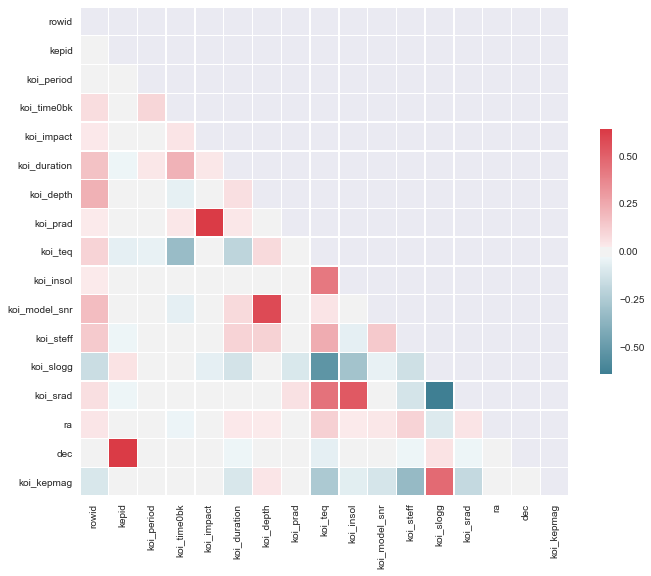

In [222]:
#create correlation matrix heatmap of the variables
import seaborn as sns
c = kepler.corr()
#print(c)
# Generate a mask for the upper triangle
mask = np.zeros_like(c, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
corrMap = sns.heatmap(c, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

#plt.savefig('corrMap.png')

In [223]:
#select only observations that are False Positive or Confirmed
cand = kepler.loc[kepler['koi_disposition'] != 'CANDIDATE']
cand.to_csv('cand.csv')
print(len(cand), len(kepler))

7015 9200


## Classification Decision Tree

In [224]:
#create test and training set for decision tree model
X.head(3)
X = cand.drop(['koi_disposition','rowid', 'kepid'], axis = 1)
y = cand.koi_disposition

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
print(len(X_train), len(X_test))
#print(y)


5612 1403


In [225]:
#fit classification decision tree
classification_tree_kepler = DecisionTreeClassifier(max_depth = 4)
fit = classification_tree_kepler.fit(X_train, y_train)
score = classification_tree_kepler.score(X_train, y_train)
print(fit)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')


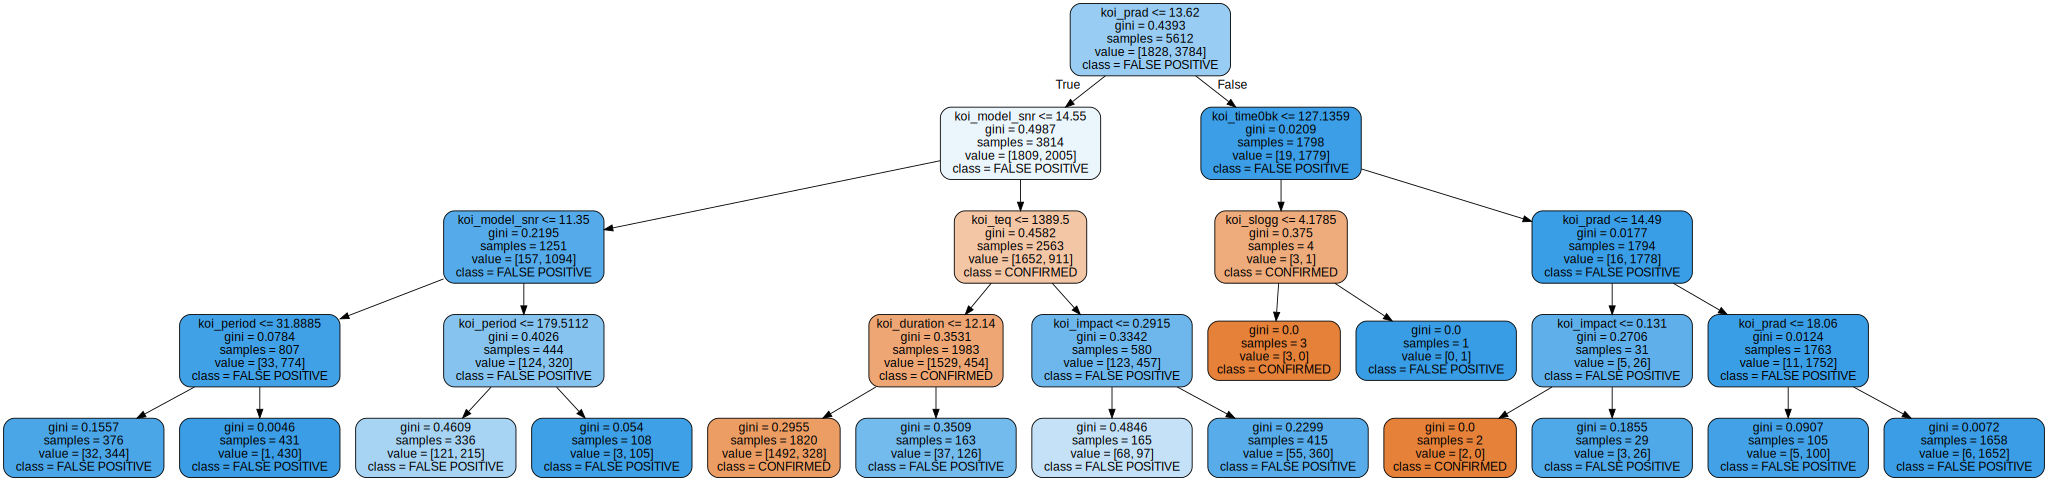

In [226]:
#export the image of the tree
export_graphviz(classification_tree_kepler, 
                out_file = "kepler_tree.dot", 
                feature_names = X_train.columns, filled = True, rounded=True, class_names = classification_tree_kepler.classes_)

with open("kepler_tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

In [227]:
#pred the results on test data and measure accuracy
pred = classification_tree_kepler.predict(X_test)
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['FALSE POSITIVE', 'CONFIRMED'], 
                  columns = ['FALSE POSITIVE', 'CONFIRMED'])
print(cm)
accuracy = (361+827)/(361+92+82+827)
print(accuracy)

                FALSE POSITIVE  CONFIRMED
FALSE POSITIVE             376         95
CONFIRMED                   88        844
0.8722466960352423


In [228]:
#check if changing size of tree will improve performance
classification_tree_kepler_large = DecisionTreeClassifier(max_depth = 8)
fit_large = classification_tree_kepler_large.fit(X_train, y_train)
score_large = classification_tree_kepler_large.score(X_train, y_train)
print(fit)
pred = classification_tree_kepler_large.predict(X_test)
cm_large = pd.DataFrame(confusion_matrix(y_test, pred).T, 
                  index = ['FALSE POSITIVE', 'CONFIRMED'], 
                  columns = ['FALSE POSITIVE', 'CONFIRMED'])
print(cm_large)
accuracy_large = (383+865)/(383+865+55+100)
print(accuracy_large)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')
                FALSE POSITIVE  CONFIRMED
FALSE POSITIVE             406        100
CONFIRMED                   58        839
0.8895224518888097


In [229]:
#Fit the classification decision tree on the candidates data to see how the objects will be predicted as confirmed or false positive
cand2 = kepler.loc[kepler['koi_disposition'] == 'CANDIDATE']
cand2pred = cand2.drop(['koi_disposition','rowid','kepid'], axis=1)

pred = classification_tree_kepler.predict(cand2pred)

print(pred)

cand2['predicted'] = pred

#cand2.to_csv('cand2.csv')

['CONFIRMED' 'CONFIRMED' 'FALSE POSITIVE' ..., 'FALSE POSITIVE'
 'FALSE POSITIVE' 'FALSE POSITIVE']


C:\Users\Kavya\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## Random Forest

In [230]:
#convert the reponse variable koi_disposition to a dummy variable in order for it be handled by the random forest
cand_disp = pd.get_dummies(cand[['koi_disposition']])

cand = cand.drop(['koi_disposition'], axis=1)
cand = pd.concat([cand, cand_disp[['koi_disposition_CONFIRMED', 'koi_disposition_FALSE POSITIVE']]], axis=1)
#print(cand)

In [231]:
X = cand.drop(['rowid', 'kepid','koi_disposition_CONFIRMED', 'koi_disposition_FALSE POSITIVE'], axis = 1)
y = cand[['koi_disposition_CONFIRMED', 'koi_disposition_FALSE POSITIVE']]

In [232]:
#fit the random forest, the max features was taken as the square root of the number ot total preditors
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8)
random_forest_cand = RandomForestRegressor(n_estimators = 100, max_features = 4, random_state = 1)

random_forest_cand.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features=4, max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=1, verbose=0, warm_start=False)

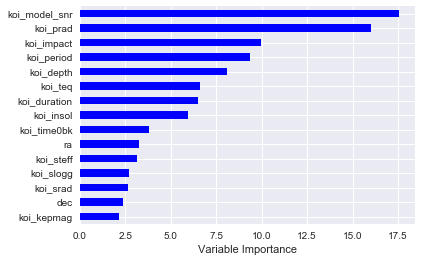

In [233]:
#plot the variable importance plot
Importance = pd.DataFrame({'Importance':random_forest_cand.feature_importances_*100}, 
                          index = X.columns)

Importance.sort_values(by = 'Importance', 
                       axis = 0, 
                       ascending = True).plot(kind = 'barh', 
                                              color = 'b', )

plt.xlabel('Variable Importance')
plt.gca().legend_ = None
plt.savefig("randomForest.png")

0.0580707056308
[[ 0.    1.  ]
 [ 0.74  0.26]
 [ 0.01  0.99]
 ..., 
 [ 0.    1.  ]
 [ 0.02  0.98]
 [ 0.    1.  ]]


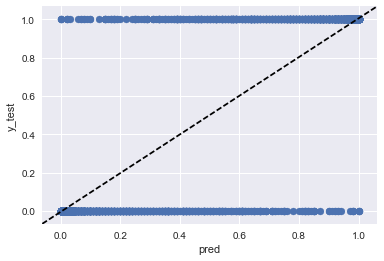

In [234]:
pred = random_forest_cand.predict(X_test)

plt.scatter(pred, 
            y_test, 
            label = 'medv')

plt.plot([0, 1], 
         [0, 1], 
         '--k', 
         transform = plt.gca().transAxes)

plt.xlabel('pred')
plt.ylabel('y_test')

print(mean_squared_error(y_test, pred))
print(pred)

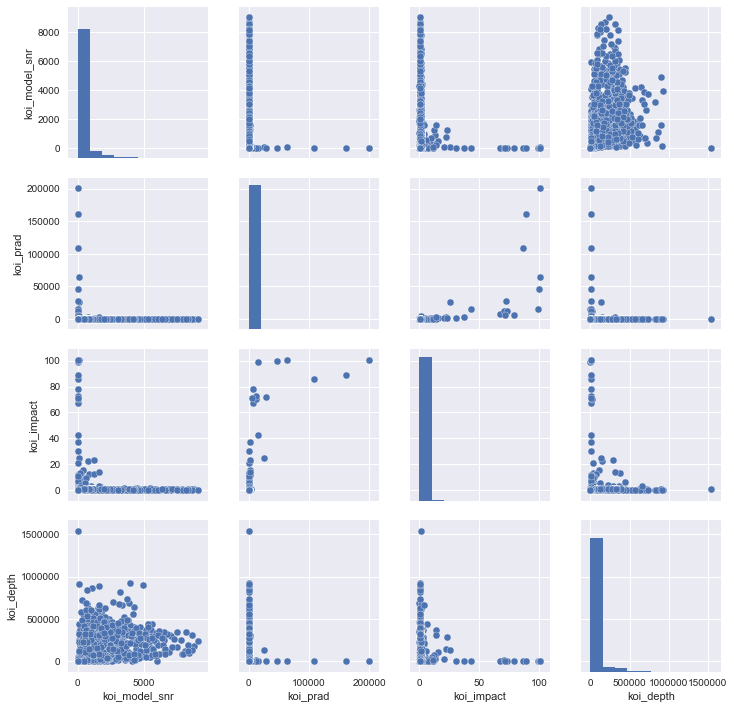

In [235]:
import seaborn as sns
sns_plot = sns.pairplot(cand[['koi_model_snr','koi_prad', 'koi_impact', 'koi_depth']])
sns_plot.savefig("pairPlot.png")

In [236]:
#predict random forest results on candidates observations
cand3 = kepler.loc[kepler['koi_disposition'] == 'CANDIDATE']
cand3pred = cand3.drop(['koi_disposition','rowid','kepid'], axis=1)
pred = random_forest_cand.predict(cand3pred)

print(pred)

[[ 0.5   0.5 ]
 [ 0.44  0.56]
 [ 0.04  0.96]
 ..., 
 [ 0.01  0.99]
 [ 0.    1.  ]
 [ 0.04  0.96]]
